## Inverse FFD

"Fitting mesh deformation to Free-Form Deformation (namely, inverse FFD)"  
Sorry, it contains some Japanese content for the clearance at this moment.  
After clearing the ambiguity, I rephrase all Japanese to English if needed.  

### Requirements

Right now, I do not use sophisticated library. I just used very common libraries for scientific computing.

- [numpy], [scipy]  
- [matplotlib]

[numpy]:https://numpy.org/
[scipy]:https://www.scipy.org/
[matplotlib]:https://matplotlib.org/

### Formulation

#### 入力データ: 頂点群 $(\mathbf{x}, \mathbf{u})$

UV座標の付与されている，$k$個の頂点を持つ頂点 $(\mathbf{x}, \mathbf{u})_k$  

- XY空間での座標 $\mathbf{x}_k = (x_k,y_k) \in \mathfrak{X} $ と
- UV空間での座標 $\mathbf{u}_k = (u_k,v_k) \in \mathfrak{U} $ を持っている．

#### 目標出力: 制御点群 $\mathrm{P}$

制御点 $B_{ij} \in \mathfrak{U}$ に対応する点 $P_{ij} \in \mathfrak{X}$  


In [1]:
## prepare mesh data for testing [TEMPORARY]
import numpy as np

x = np.array([
    [ 0.5775, 0.2275 ], [ 0.74, 0.2525 ],
    [ 0.5425, 0.3225 ], [ 0.6375, 0.365 ], [ 0.7025, 0.3925 ],
    [ 0.535, 0.405 ], [ 0.62, 0.495 ], [ 0.7125, 0.555 ],
    [ 0.54, 0.52 ], [ 0.6225, 0.6475 ],
    [ 0.445, 0.505 ], [ 0.495, 0.6675 ], [ 0.585, 0.7475 ],
    [ 0.3575, 0.49 ], [ 0.34, 0.62 ], [ 0.36, 0.72 ], [ 0.47, 0.7675 ],
    [ 0.2, 0.51 ], [ 0.2425, 0.6575 ]
])

u = np.array([
    [ 0.5325, 0.095 ], [ 0.6875, 0.11 ],
    [ 0.49, 0.1775 ], [ 0.5775, 0.2175 ], [ 0.66, 0.2475 ],
    [ 0.4725, 0.2675 ], [ 0.575, 0.345 ], [ 0.6475, 0.425 ],
    [ 0.525, 0.4775 ], [ 0.635, 0.5375 ],
    [ 0.3925, 0.58 ], [ 0.525, 0.6425 ], [ 0.6125, 0.705 ],
    [ 0.2975, 0.6325 ], [ 0.3875, 0.71 ], [ 0.4875, 0.76 ], [ 0.5775, 0.805 ],
    [ 0.2825, 0.77 ], [ 0.4, 0.855 ]
])

tri = [
    [ 0,  2,  3], [ 0,  1,  3], [ 1,  3,  4], [ 2,  3,  5], [ 3,  4,  6], 
    [ 3,  5,  6], [ 4,  6,  7], [ 5,  6,  8], [ 5,  8, 10], [ 6,  7,  9],
    [ 6,  8,  9], [ 8,  9, 11], [ 8, 10, 11], [ 9, 11, 12], [10, 13, 14],
    [11, 12, 16], [11, 14, 15], [11, 15, 16], [13, 14, 18], [13, 17, 18],
    [14, 15, 18],
]

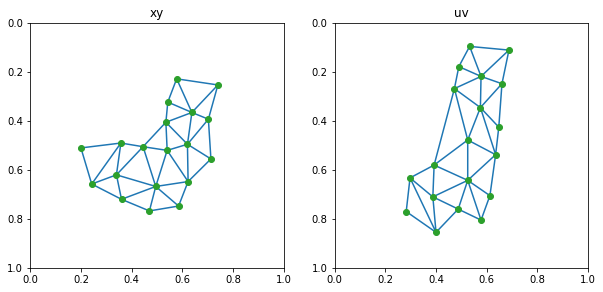

In [2]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5))

ax1.set_xlim([0.0,1.0])
ax1.set_ylim([0.0,1.0])
ax1.invert_yaxis()

ax1.triplot(x[:,0], x[:,1], tri)
ax1.plot(x[:,0], x[:,1], 'o')

ax2.set_xlim([0.0,1.0])
ax2.set_ylim([0.0,1.0])
ax2.invert_yaxis()

ax2.triplot(u[:,0], u[:,1], tri)
ax2.plot(u[:,0], u[:,1], 'o')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

### Procedure

#### Initialization: グリッド点 $\mathrm{B}$ (自動生成)

1. Bounding Box を計算する (単純)  
2. Subdivision few times **$\leftarrow$ まず適当に回数を決める**  
3. Bounding box の成す頂点が $B_{ij}$ となる  


In [3]:
## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

print(u_min, v_min, u_max, v_max)

0.2825 0.095 0.6875 0.855


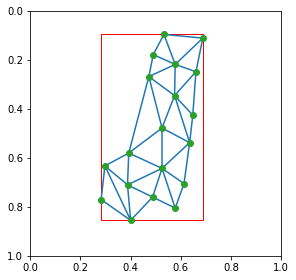

In [4]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(4.5,4.5))

ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])
ax.invert_yaxis()

ax.triplot(u[:,0], u[:,1], tri)
ax.plot(u[:,0], u[:,1], 'o')

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

In [5]:
## subdivide bounding box
## [TEMPORARY] just twice for u-axis and four times for v-axis
B_i = np.linspace(u_min, u_max, num=3)
B_j = np.linspace(v_min, v_max, num=5)

B_ix, B_jy = np.meshgrid(B_i, B_j)

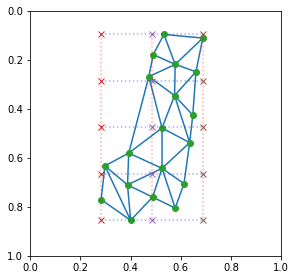

In [6]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(4.5,4.5))

ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])
ax.invert_yaxis()

ax.triplot(u[:,0], u[:,1], tri)
ax.plot(u[:,0], u[:,1], 'o')

## grid points
ax.plot(B_ix, B_jy, 'x')

## draw lines between grid points
for Bx in B_i:
    plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

plt.show()

In [7]:
## get the grid points B_{ij}
#B_ij = np.array(list(zip(B_ix.reshape(-1), B_jy.reshape(-1))))
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2) ## more NumPy way to implement this

#print(B_ij)
;

''


#### Definition of cost function $\mathcal{O}$

$\mathcal{O} = \sum_k{ |\mathbf{x}_k - X(\mathbf{u}_k, \mathrm{P})|^2 } $
where
$X(\mathbf{u}, \mathrm{P}) = \sum_{ij}{ {B}_{ij}(\mathbf{u}) \cdot {P}_{ij} }$  

現在，$ {B}_{ij}(\mathbf{u})$ はその$\mathbf{u}$を囲っている4つの制御点までの補間における単純重みとしている． <mark>(改善の余地あり)</mark>  

#### Minimization of $\mathcal{O}$

$X$の計算は線形的であり，最小二乗法で簡単に解けるはず  

### Construction of sparse matrix

最後に，疎行列ソルバーを用いて最小二乗法を解く方法について触れておく．  

- $\mathbf{x}$: 定数項として働く, $({k},{2})$, 既知  
- $\mathrm{P}$: 2次元のグリッド交差点数 $({i}\times{j},{2})$, **<mark>未知</mark>**  
- $B_{ij}(\mathbf{u})$: 2次元のグリッド交差点とUV座標からなる疎行列, $({k},{{i}\times{j}})$  

$$ \begin{pmatrix}
    \mathbf{x}_1 \\
    \mathbf{x}_2 \\
    \vdots \\
    \mathbf{x}_k \\
  \end{pmatrix}
- \begin{bmatrix} B_{ij}(\mathbf{u}) \end{bmatrix}
  \begin{pmatrix} 
    P_{11} \\
    P_{12} \\
    \vdots \\
    P_{ij} \\
  \end{pmatrix} $$
  
行列$\mathrm{B}$の成分$B_{ij}(\mathbf{u})$は，グリッド内であるかを判定し，各制御点までの線形補間の値としているため，行列$B_{ij}(\mathbf{u})$には行辺り４つの成分しか存在しない．  
$k$行目に注目してみれば容易に検証可能である:  

$$ \begin{pmatrix} \vdots \\ \mathbf{x}_k \\ \vdots \end{pmatrix}
- \begin{bmatrix}
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
    \cdots & {B}_{i,j}(\mathbf{u}_k) & {B}_{i+1,j}(\mathbf{u}_k ) &
    \cdots & {B}_{i,j+1}(\mathbf{u}_k) & {B}_{i+1,j+1}(\mathbf{u}_k) & \cdots \\
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
  \end{bmatrix}
  \begin{pmatrix} \vdots \\ P_{i,j} \\ P_{i+1,j} \\ \vdots \\ P_{i,j+1} \\ P_{i+1,j+1} \\ \vdots \end{pmatrix}
$$


最後に，通常の最小二乗法のソルバーに落とし込むために，２次元の列部分を１次元化に落とす:  

$$ \begin{pmatrix} \vdots \\ x_k \\ y_k \\ \vdots \end{pmatrix}
- \begin{bmatrix}
    {} &\vdots & \vdots & \vdots & \vdots & {} & \vdots & \vdots & \vdots & \vdots & {} \\
    \cdots & w_i w_j & {\cdot} & w_{i+1} w_j & {\cdot} &
    \cdots & w_i w_{j+1} & {\cdot} & w_{i+1} w_{j+1} & {\cdot} & \cdots \\
    \cdots & {\cdot} & w_i w_j & {\cdot} & w_{i+1} w_j &
    \cdots & {\cdot} & w_i w_{j+1} & {\cdot} & w_{i+1} w_{j+1} & \cdots \\
    {} &\vdots & \vdots & \vdots & \vdots & {} & \vdots & \vdots & \vdots & \vdots & {} \\
  \end{bmatrix}
  \begin{pmatrix}
    \vdots \\ P_{i,j}^x \\ P_{i,j}^y \\ P_{i+1,j}^x \\ P_{i+1,j}^y \\
    \vdots \\ P_{i,j+1}^x \\ P_{i,j+1}^y \\ P_{i+1,j+1}^x \\ P_{i+1,j+1}^y \\ \vdots
  \end{pmatrix}
$$

$$
= \tilde{\mathbf{x}} - \begin{bmatrix} \tilde{B_{ij}}(\mathbf{u}) \end{bmatrix} \tilde{\mathrm{P}}
$$

まとめると，  

- $\tilde{\mathbf{x}}$: 定数項として働く行ベクトル $({k}\times{2},1)$   
- $\tilde{\mathrm{B}}$: 2次元のグリッド交差点とUV座標からなる疎行列, $({k}\times{2},{{i}\times{j}\times{2}})$
- $\tilde{\mathrm{P}}$: 未知数の，2次元のグリッド交差点の座標を表す行ベクトル $({i}\times{j}\times{2},1)$  


In [8]:
## construct sparse matrix
from scipy.sparse import dok_matrix

B_tilde = dok_matrix((x.size, B_ij.size), dtype=np.float32)

def ForEachUV(k, u_k, v_k):
    
    for i in range(len(B_i)-1):
        if (B_i[i] <= u_k and u_k <= B_i[i+1]):
            break
    
    for j in range(len(B_j)-1):
        if (B_j[j] <= v_k and v_k <= B_j[j+1]):
            break
    
    w_i = (B_i[i+1]-u_k) / (B_i[i+1]-B_i[i])
    w_j = (B_j[j+1]-v_k) / (B_j[j+1]-B_j[j])
    
    #print("{0},\t{1} \t-> ({2},{3}), weight = ({4},{5})".format(u_k, v_k, i, j, w_i, w_j))
    
    ## assign each elements into sparse matrix
    B_row = 2 * k

    B_col_i0j0 = 2 * ((i+0) + (j+0)*len(B_i) )
    B_col_i1j0 = 2 * ((i+1) + (j+0)*len(B_i) )
    B_col_i0j1 = 2 * ((i+0) + (j+1)*len(B_i) )
    B_col_i1j1 = 2 * ((i+1) + (j+1)*len(B_i) )
    
    B_tilde[B_row  , B_col_i0j0  ] = w_i*w_j
    B_tilde[B_row+1, B_col_i0j0+1] = w_i*w_j
    B_tilde[B_row  , B_col_i0j1  ] = w_i*(1.0-w_j)
    B_tilde[B_row+1, B_col_i0j1+1] = w_i*(1.0-w_j)
    
    B_tilde[B_row  , B_col_i1j0  ] = (1.0-w_i)*w_j
    B_tilde[B_row+1, B_col_i1j0+1] = (1.0-w_i)*w_j
    B_tilde[B_row  , B_col_i1j1  ] = (1.0-w_i)*(1.0-w_j)
    B_tilde[B_row+1, B_col_i1j1+1] = (1.0-w_i)*(1.0-w_j)
    
    return None

for k in range(len(u)):
    uv_k = u[k]
    ForEachUV(k, uv_k[0], uv_k[1])


In [9]:
## constant part is relatively easy, just make it as 1-dim vector...
x_tilde = x.reshape(-1)

In [10]:
## solve Least-Squares problem with scipy.sparse:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html
from scipy.sparse.linalg import lsqr

P_tilde, isstop, itn, r1norm = lsqr(B_tilde, x_tilde)[:4]

print(isstop, itn, r1norm)

2 15 0.049876459725101484


In [11]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

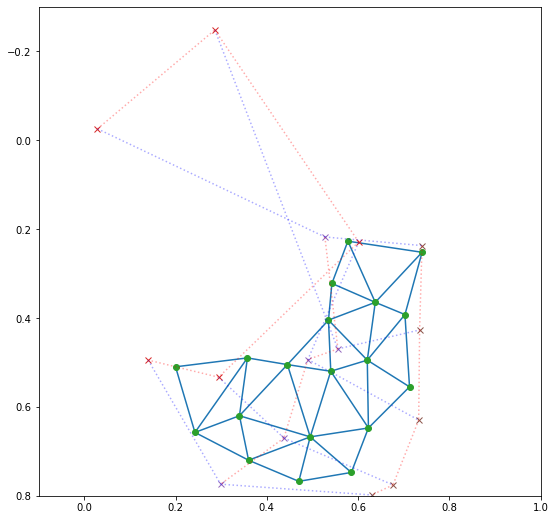

In [12]:
## visualize control points in X-space
fig, ax = plt.subplots(figsize=(9,9))

ax.set_xlim([-0.1,1.0])
ax.set_ylim([-0.3,0.8])
ax.invert_yaxis()

ax.triplot(x[:,0], x[:,1], tri)
ax.plot(x[:,0], x[:,1], 'o')

## grid points
ax.plot(P_ix, P_jy, 'x')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

plt.show()

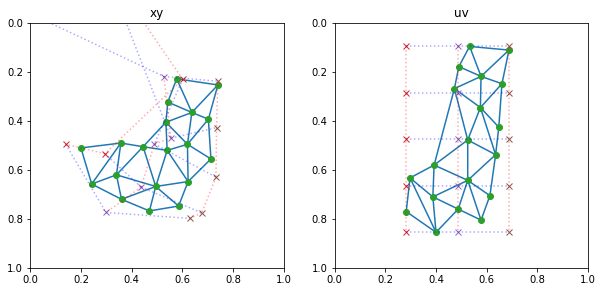

In [13]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5))

########################################
## XY space
########################################
ax1.set_xlim([0.0,1.0])
ax1.set_ylim([0.0,1.0])
ax1.invert_yaxis()

ax1.triplot(x[:,0], x[:,1], tri)
ax1.plot(x[:,0], x[:,1], 'o')

## grid points
ax1.plot(P_ix, P_jy, 'x')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([0.0,1.0])
ax2.set_ylim([0.0,1.0])
ax2.invert_yaxis()

ax2.triplot(u[:,0], u[:,1], tri)
ax2.plot(u[:,0], u[:,1], 'o')

## grid points
ax2.plot(B_ix, B_jy, 'x')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

## TODOs

- Feeding the actual XY-UV meshes  
- Adding regularization term  
- Avoiding zero assigned grid points (if needed)  
- Keeping consistency between forward and inverse FFD


(end)